In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

/Users/louis/mambaforge/envs/dLux_test/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import pickle as p
import equinox as eqx
import optax
import functools as ft # used for filtering
from tqdm.notebook import tqdm

In [3]:
from dLux.base import *
from dLux.layers import *
from dLux.propagators import *

In [4]:
def rand(shape):
    return np.array(onp.random.rand(np.prod(np.array(shape))).reshape(shape))

def norm(mean, deviation, shape):
    return np.array(onp.random.normal(mean, deviation, shape))

def calc_pixsize(Nyq_rate, wavel, optic_size, focal_length):
    """ Assumes Airy disk """
    airy_fringe = focal_length * 1.22*wavel / optic_size
    det_pixelsize = 1/Nyq_rate * 0.5 * airy_fringe
    return det_pixelsize

def rad2arcsec(values):
    return values * 3600 * 180 / np.pi

def arcsec2rad(values):
    return values * np.pi / (3600 * 180)

---

## Input Parameters

 - optic size: Diameter of the aperture
 - focal lenght: Focal length of the primary mirror/lens
 - oversample: Oversampling rate of the wavefront/optic 


In [5]:
# Define Parameters (Optical)
optic_size = 1.         # Physical size of input optic array, ie aperture size for simple system (m)
fl = 10.                # Focal length (m)

# Define Parameters (Arrays/sizes)
optic_npix = 128        # Number of pixels in the wf/optic before oversampling (pix)
oversample = 4          # Oversapling/padding factor
det_npix = 512          # Number of pixels in the focal plane

# Spectral Params
min_wavel = 400e-9
max_wavel = 600e-9
nwavels = 5

# Sample in the focal plane at 2x Nyquist for shortest wavel
Nyq_rate = 2
Nstars = 10
Nzern = 6 # Ignore Piston, Tip, Tilt, Defocus

In [6]:
wavels = np.linspace(min_wavel, max_wavel, nwavels)
mean_wavel = (max_wavel + min_wavel)/2 # Mean wavelength

wf_npix = optic_npix * oversample # Size of padded WF
# det_pixsize = calc_pixsize(Nyq_rate, min_wavel, optic_size, fl)
det_pixsize = calc_pixsize(4, min_wavel, optic_size, fl)

Nims = 4
dithers = 2e-6 * np.array([[+1, +1],
                           [+1, -1],
                           [-1, +1],
                           [-1, -1]])

In [7]:
onp.random.seed(3)
BG_noise = norm(0, 0.1, [det_npix, det_npix])

---

## Parameters being Optimised

In [8]:
# Optical Parameters:
# Zernike Coefficients & Focal Shift
coefficients = 5e-8 * np.array(onp.random.normal(0, 0.5, Nzern))
fl_shift = 1e-3 # (m)
pix_response = norm(1, 0.05, [det_npix, det_npix])

# Astrophysical Parameters
# Stellar Fluxes & Positions
fluxes = norm(1e6, 1e5, Nstars)
# positions = 1e-5*(2*rand([Nstars, 2]) - 1)
positions = 1e-5*(2*rand([Nstars, 2]) - 1)

### Construct Optical System

Note: Weird Behaviour

 - Applying the Aperture before the Zernikes give nan gradients for the positional paramters, but applying Zernikes first seems to work just fine...

In [9]:
optical_layers = [
    # 1: Wavefront creation
    CreateWavefront(optic_npix, optic_size),
    # 2: Apply Zernike Polynomials
    ApplyZernike(optic_npix, Nzern, coefficients, defocus=False),
    # 3: Apply ciruclar aperture
    # MultiplyArray(optic_npix, aperture),
    CircularAperture(optic_npix),
    # 4: Thin lens for Fresnel prop
    ThinLens(optic_npix, fl, optic_size),
    # 5: Pad for Fresnel prop
    Pad(optic_npix, wf_npix),
    # 6: Fresnel prop
    FresnelProp(wf_npix, fl, fl-fl_shift),
    # 7: Normalise PSF intensity post Fresnel prop
    NormaliseWavefront(wf_npix),
    # 8: Interpolate WF onto detector
    Interpolator(wf_npix, det_npix, det_pixsize),
    # 9: Calcualte PSF from wavefront
    Wavefront2PSF(det_npix)]

detector_layers = [ApplyPixelResponse(det_npix, pix_response)]

Ignoring Piston Tip Tilt Defocus


In [10]:
scene = Scene(
    OpticalSystem(optical_layers), 
    wavels, 
    positions, 
    fluxes, 
    detector_layers=detector_layers, 
    dithers=dithers)

p.dump(scene, open("models/scene_1.p", "wb" ))

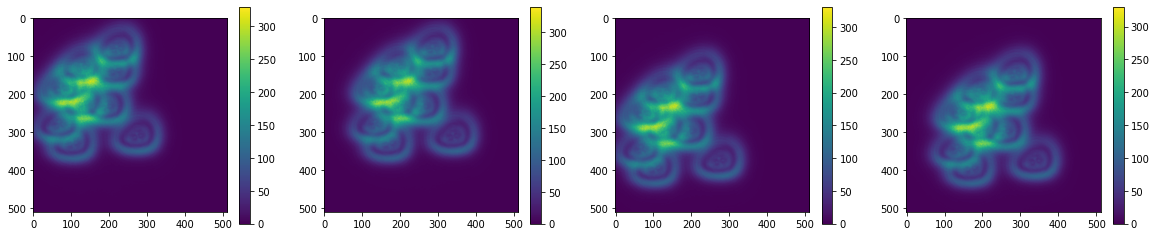

In [11]:
data = scene() + BG_noise

plt.figure(figsize=(Nims*5, 4))
for i in range(Nims):
    plt.subplot(1, Nims, i+1)
    plt.imshow(data[i])
    plt.colorbar()
plt.show()

---

## Perturb initial parameters

In [12]:
layers_init = optical_layers
layers_init[1] = ApplyZernike(optic_npix, Nzern, np.zeros([Nzern]), defocus=False) 
layers_init[5] = FresnelProp(wf_npix, fl, fl-fl_shift/1.25)

positions_init = positions + 1e-6*norm(0, 0.2, [Nstars, 2])
fluxes_init = fluxes * norm(1, 0.1, [Nstars])
detector_layers_init = [ApplyPixelResponse(det_npix, np.ones([det_npix, det_npix]))]

Ignoring Piston Tip Tilt Defocus


In [13]:
opt_model = Scene(
    OpticalSystem(layers_init), 
    wavels, 
    positions_init, 
    fluxes_init, 
    detector_layers=detector_layers_init, 
    dithers=dithers)

p.dump(opt_model, open("models/model_init_1.p", "wb" ))

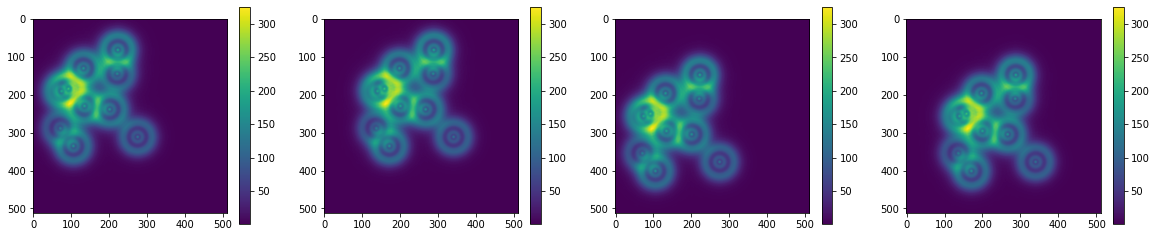

In [14]:
psfs_init = opt_model()

plt.figure(figsize=(Nims*5, 4))
for i in range(Nims):
    plt.subplot(1, Nims, i+1)
    plt.imshow(psfs_init[i])
    plt.colorbar()
plt.show()

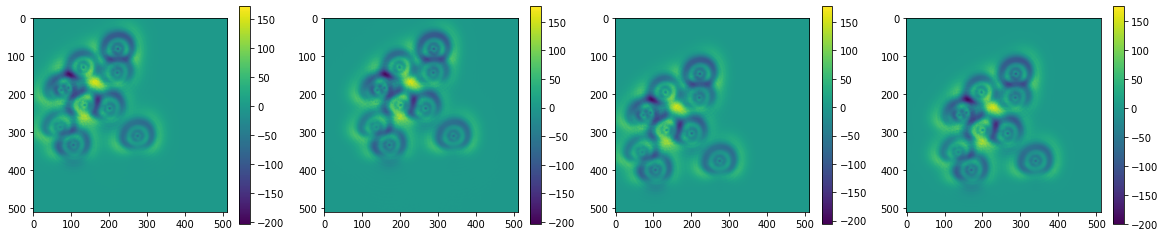

In [15]:
plt.figure(figsize=(Nims*5, 4))
for i in range(Nims):
    plt.subplot(1, Nims, i+1)
    plt.imshow(data[i] - psfs_init[i])
    plt.colorbar()
plt.show()

In [16]:
model_out = [opt_model]

# Default values to group 0
filter_spec = jax.tree_map(lambda _: False, model_out)

# Set filtering Tree
filter_spec = eqx.tree_at(lambda scene: scene[0].positions,                             filter_spec, replace=True)
filter_spec = eqx.tree_at(lambda scene: scene[0].fluxes,                                filter_spec, replace=True)
filter_spec = eqx.tree_at(lambda scene: scene[0].optical_system.layers[1].coefficients, filter_spec, replace=True)
filter_spec = eqx.tree_at(lambda scene: scene[0].optical_system.layers[5].z,            filter_spec, replace=True)
filter_spec = eqx.tree_at(lambda scene: scene[0].detector_layers[0].pixel_response,     filter_spec, replace=True)

In [17]:
@eqx.filter_jit
@ft.partial(eqx.filter_value_and_grad, filter_spec=filter_spec)
def loss_func(model, data):
    out = model[0]()
    return np.mean((out - data)**2)

In [18]:
%%time
_ = loss_func(model_out, data) # Compile

print("Initial Loss: {}".format(int(_[0])))

Initial Loss: 691
CPU times: user 33.8 s, sys: 2.45 s, total: 36.2 s
Wall time: 15.8 s


In [19]:
_[0]

DeviceArray(691.07557617, dtype=float64)

In [20]:
param_spec =  jax.tree_map(lambda _: "null", model_out)

# Set parameter groups
param_spec = eqx.tree_at(lambda scene: scene[0].positions,                             param_spec, replace='positions')
param_spec = eqx.tree_at(lambda scene: scene[0].fluxes,                                param_spec, replace='fluxes')
param_spec = eqx.tree_at(lambda scene: scene[0].optical_system.layers[1].coefficients, param_spec, replace='coeffs')
param_spec = eqx.tree_at(lambda scene: scene[0].optical_system.layers[5].z,            param_spec, replace='prop_dist')
param_spec = eqx.tree_at(lambda scene: scene[0].detector_layers[0].pixel_response,     param_spec, replace='FF')

FF_sched = optax.piecewise_constant_schedule(init_value=1e-8, boundaries_and_scales={50:int(1e6)})

optim = optax.multi_transform(
    {"null":        optax.adam(0.0), 
     "positions":   optax.adam(5e-8), 
     "fluxes":      optax.adam(5e4),
     "prop_dist":   optax.adam(5e-5),
     "coeffs":      optax.adam(5e-9),
     "FF":          optax.adam(FF_sched)},
    param_spec)

opt_state = optim.init(eqx.filter(model_out, eqx.is_array_like))

In [21]:
errors, grads_out, models_out = [], [], []

model_out = [opt_model] # Re-initialise Model
for i in tqdm(range(250)):
    loss, grads = loss_func(model_out, data)    

    updates, opt_state = optim.update(grads, opt_state)
    model_out = eqx.apply_updates(model_out, updates)
    errors.append(loss)
    grads_out.append(grads)
    models_out.append(model_out)
    
    if i%10 == 0:
        print(i, loss)
    
psfs_out = model_out[0]()

  0%|          | 0/250 [00:00<?, ?it/s]

0 691.0755761720793
10 103.94686702246119
20 49.0323529582732
30 24.697302566493672
40 16.76632741918042
50 13.932047218169574
60 1.7195043922926458
70 1.3989447237640749
80 0.5227828119386531
90 0.1602468552407722
100 0.06368179814248515
110 0.02738725905957136
120 0.012840738562346002
130 0.007196198640886955
140 0.005079702610961077
150 0.0042625865768676705
160 0.003888731814716202
170 0.0037115670980839943
180 0.0036221399643103424
190 0.003568533971915279
200 0.0035340763810942522
210 0.003510438069039565
220 0.003493340903349404
230 0.00348060823849525
240 0.0034708646563384464


In [40]:
# p.dump([model_out, opt_state, optim], open("models/opt_list_{}.p".format(i+1), "wb" ))
p.dump(model_out, open("models/model_out_with_FF.p", "wb" ))
p.dump(models_out, open("models/models_out.p", "wb" ))

In [23]:
psfs_out = model_out[0]()
positions_found = np.array([models_out[i][0].positions for i in range(len(models_out))])
fluxes_found = np.array([models_out[i][0].fluxes for i in range(len(models_out))])
coeffs_found = np.array([models_out[i][0].optical_system.layers[1].coefficients  for i in range(len(models_out))])
prs_found = np.array([models_out[i][0].detector_layers[0].pixel_response  for i in range(len(models_out))])

In [24]:
final_model = model_out[0]
errors = np.array(errors)


coeff_residuls = coefficients - coeffs_found
flux_residuls = fluxes - fluxes_found

scaler = 1e3
z_true = scaler*(fl-fl_shift)
zs_found = scaler*np.array([models_out[i][0].optical_system.layers[5].z 
                            for i in range(len(models_out))])

positions_residuls = positions - positions_found
r_residual_rads = np.hypot(positions_residuls[:, :, 0], positions_residuls[:, :, 1])
r_residual = rad2arcsec(r_residual_rads)

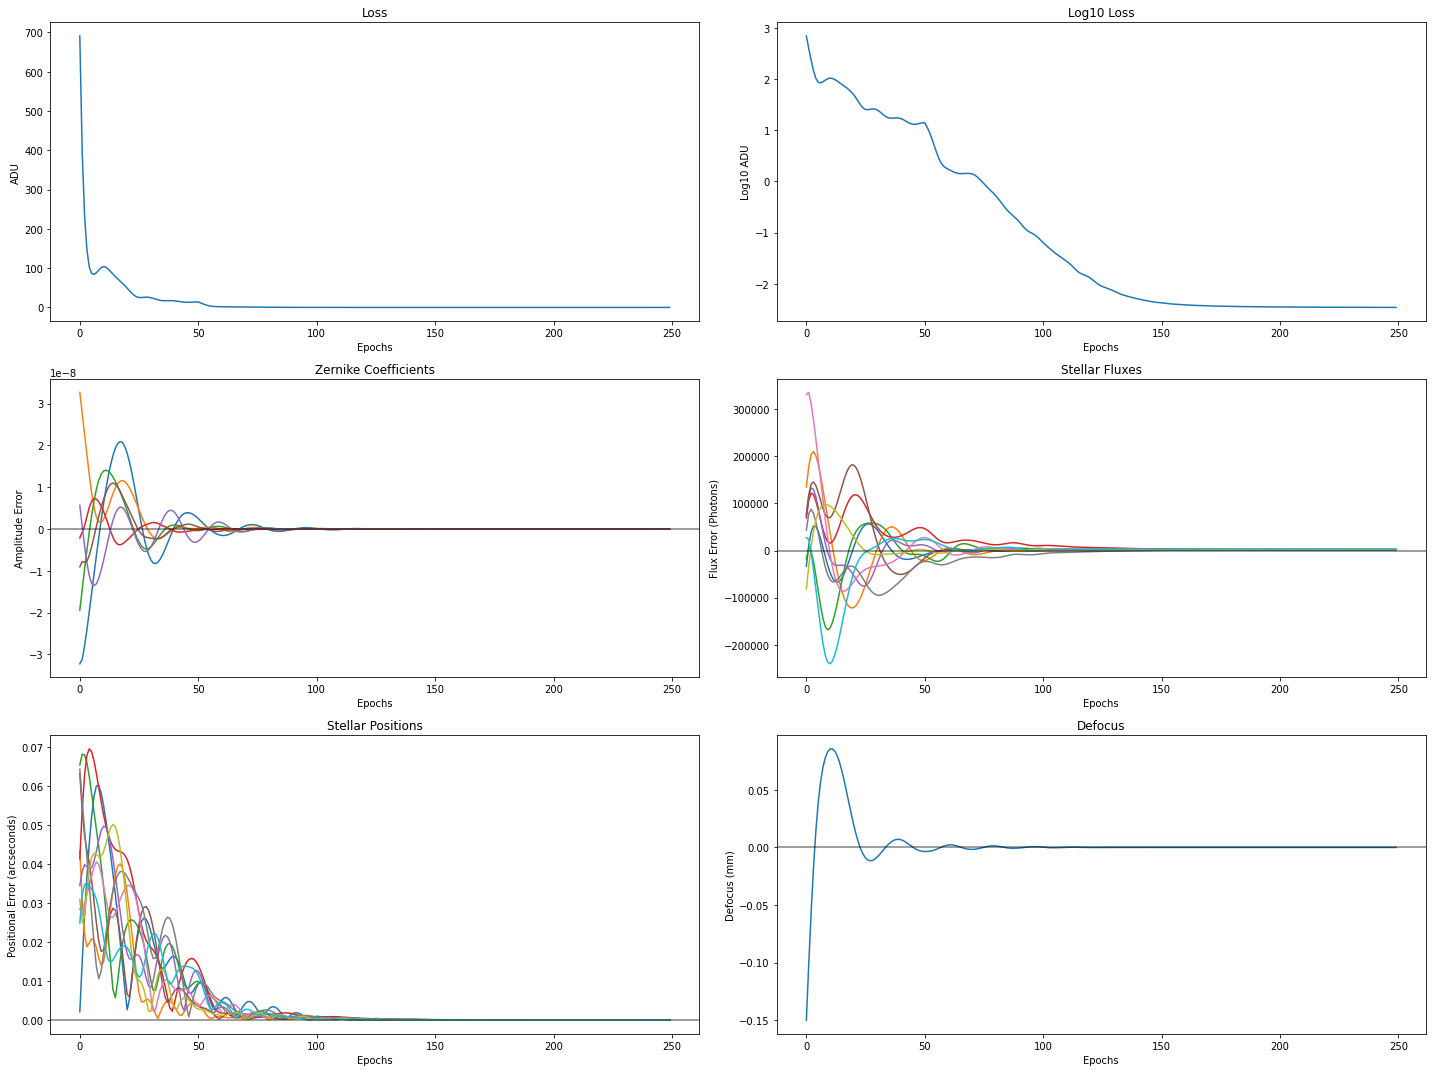

In [34]:

plt.figure(figsize=(20, 15))
plt.subplot(3, 2, 1)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("ADU")
plt.plot(errors)

plt.subplot(3, 2, 2)
plt.title("Log10 Loss")
plt.xlabel("Epochs")
plt.ylabel("Log10 ADU")
plt.plot(np.log10(errors))

plt.subplot(3, 2, 3)
plt.title("Zernike Coefficients")
plt.xlabel("Epochs")
plt.ylabel("Amplitude Error")
plt.plot(coeff_residuls)
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(3, 2, 4)
plt.title("Stellar Fluxes")
plt.xlabel("Epochs")
plt.ylabel("Flux Error (Photons)")
plt.plot(flux_residuls)
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(3, 2, 5)
plt.title("Stellar Positions")
plt.xlabel("Epochs")
plt.ylabel("Positional Error (arcseconds)")
plt.plot(r_residual)
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(3, 2, 6)
plt.title("Defocus")
plt.xlabel("Epochs")
plt.ylabel("Defocus (mm)")
plt.plot(z_true - zs_found)
plt.axhline(0, c='k', alpha=0.5)

plt.tight_layout()
plt.show()

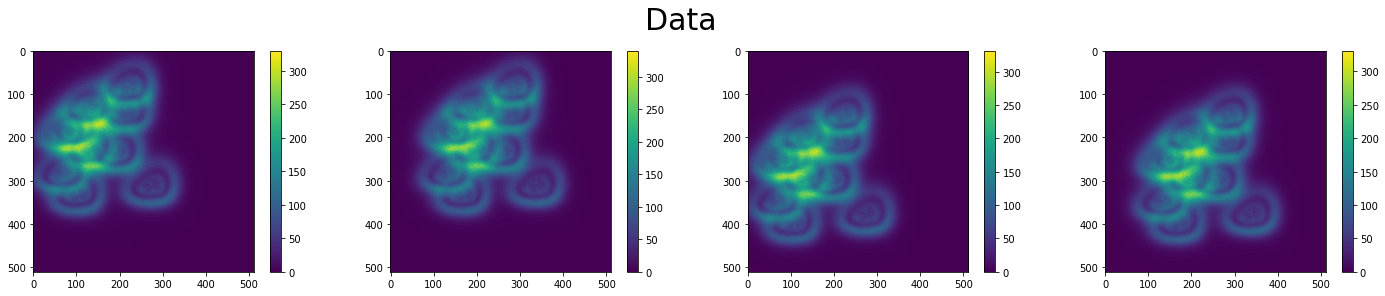

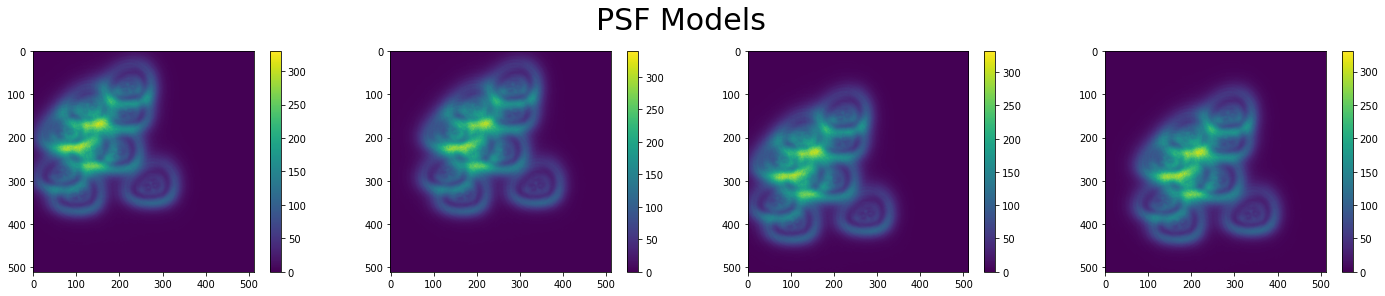

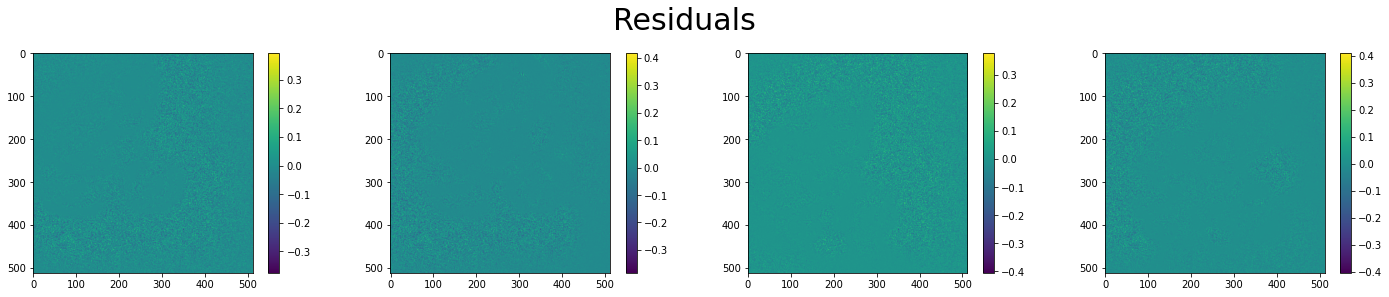

In [35]:
plt.figure(figsize=(Nims*5, 4))
plt.suptitle("Data", fontsize=30)
for i in range(Nims):
    plt.subplot(1, Nims, i+1)
    plt.imshow(data[i])
    plt.colorbar()
plt.tight_layout()
plt.show()
    
plt.figure(figsize=(Nims*5, 4))
plt.suptitle("PSF Models", fontsize=30)
for i in range(Nims):
    plt.subplot(1, Nims, i+1)
    plt.imshow(psfs_out[i])
    plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(Nims*5, 4))
plt.suptitle("Residuals", fontsize=30)
for i in range(Nims):
    plt.subplot(1, Nims, i+1)
    plt.imshow(data[i] - psfs_out[i])
    plt.colorbar()
plt.tight_layout()
plt.show()

Ignoring Piston Tip Tilt Defocus
Ignoring Piston Tip Tilt Defocus


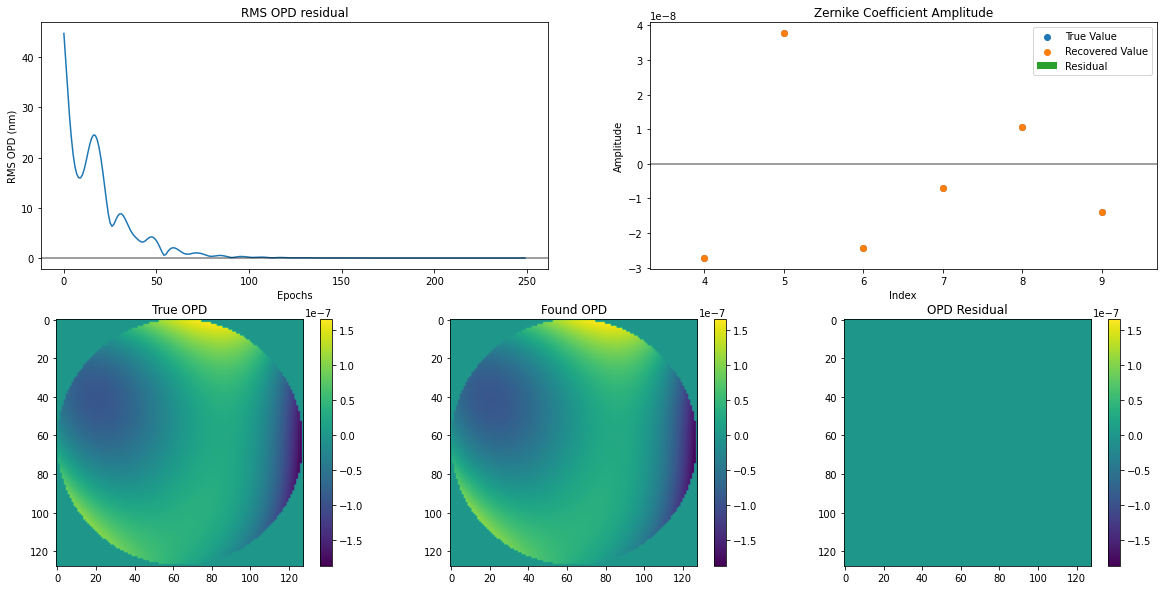

In [36]:
# OPDs
true_opd = ApplyZernike(optic_npix, Nzern, coefficients, defocus=False).get_total_opd()
opds_found = np.array([models_out[i][0].optical_system.layers[1].get_total_opd()  for i in range(len(models_out))])
found_opd = opds_found[-1]
opd_residuls = true_opd - opds_found
opd_rmse_nm = 1e9*np.mean(opd_residuls**2, axis=(-1,-2))**0.5

vmin = np.min(np.array([true_opd, found_opd]))
vmax = np.max(np.array([true_opd, found_opd]))

# Coefficients
true_coeff = ApplyZernike(optic_npix, Nzern, coefficients, defocus=False).coefficients
found_coeff = final_model.optical_system.layers[1].coefficients
index = np.arange(len(true_coeff))+4

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.title("RMS OPD residual")
plt.xlabel("Epochs")
plt.ylabel("RMS OPD (nm)")
plt.plot(opd_rmse_nm)
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(2, 2, 2)
plt.title("Zernike Coefficient Amplitude")
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.scatter(index, true_coeff, label="True Value")
plt.scatter(index, found_coeff, label="Recovered Value")
plt.bar(index, true_coeff - found_coeff, label='Residual')
plt.axhline(0, c='k', alpha=0.5)
plt.legend()


plt.subplot(2, 3, 4)
plt.title("True OPD")
plt.imshow(true_opd)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.title("Found OPD")
plt.imshow(found_opd)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.title("OPD Residual")
plt.imshow(true_opd - found_opd, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

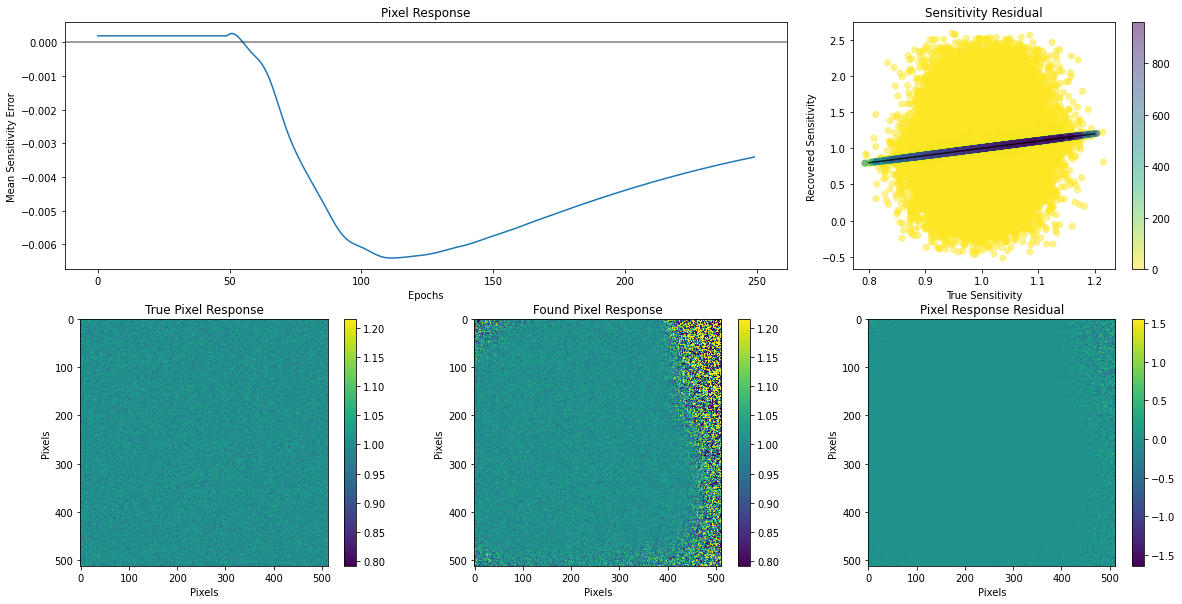

In [37]:
true_pr = pix_response
found_pr = prs_found[-1]

# FF Scatter Plot
data_sum = data.sum(0) # [flux_mask]
colours = data_sum.flatten()
ind = np.argsort(colours)
colours = colours[ind]
pr_true_flat = pix_response.flatten()
pr_found_flat = prs_found[-1].flatten()
pr_true_sort = pr_true_flat[ind]
pr_found_sort = pr_found_flat[ind]

pr_residuls = true_pr - prs_found
pr_error = pr_residuls.mean((-1, -2))

vmin = np.min(true_pr)
vmax = np.max(true_pr)

plt.figure(figsize=(20, 10))
plt.subplot(2, 3, (1,2))
plt.title("Pixel Response")
plt.xlabel("Epochs")
plt.ylabel("Mean Sensitivity Error")
plt.plot(pr_error)
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(2, 3, 3)
plt.plot(np.linspace(0.8, 1.2), np.linspace(0.8, 1.2), c='k', alpha=0.75)
plt.scatter(pr_true_sort, pr_found_sort, c=colours, cmap='viridis_r', alpha=0.5)
plt.colorbar()
plt.title("Sensitivity Residual")
plt.ylabel("Recovered Sensitivity")
plt.xlabel("True Sensitivity")

plt.subplot(2, 3, 4)
plt.title("True Pixel Response")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(true_pr)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.title("Found Pixel Response")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(found_pr, vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.title("Pixel Response Residual")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(true_pr - found_pr)
plt.colorbar()

plt.show()

In [29]:
# im_residuals = []
# for i in tqdm(range(len(models_out))):
#     im_residuals.append(data[0] - models_out[i][0]()[0])
# im_residuals = np.array(im_residuals)

  0%|          | 0/250 [00:00<?, ?it/s]

In [51]:
# import imageio

# def inv_support(npix):
#     xs = np.arange(-npix//2, npix//2)
#     XX, YY = np.meshgrid(xs, xs)
#     RR = np.hypot(XX, YY)
#     return np.where(RR >= npix//2)

# true_pr = pix_response
# found_pr = prs_found[-1]

# prs_found = np.array([models_out[i][0].detector_layers[0].pixel_response  for i in range(len(models_out))])

# # FF Scatter Plot
# data_sum = data.sum(0) # [flux_mask]
# colours = data_sum.flatten()
# ind = np.argsort(colours)
# colours = colours[ind]

# # Pixel Responses
# pr_true_flat = pix_response.flatten()
# pr_true_sort = pr_true_flat[ind]

# # Image Residuals
# vmin=np.min(im_residuals)
# vmax=np.max(im_residuals)
# v_im = np.max(np.array([np.abs(vmin), vmax]))

# # OPDs
# opd_mask = inv_support(optic_npix)
# opd_residuls = true_opd - opds_found
# vmin = np.min(np.array([true_opd, found_opd]))
# vmax = np.max(np.array([true_opd, found_opd]))
# v_OPD = np.max(np.array([np.abs(vmin), vmax]))

# defoc_resids = z_true - zs_found


# filenames = []
# nepoch = len(models_out)
# idxs = np.arange(0, nepoch, 1)
# for i in tqdm(idxs):
#     plt.figure(figsize=(18, 10))

#     ax = plt.subplot(2, 3, (1,2))
#     plt.title("Loss")
#     plt.xlabel("Epochs")
#     plt.ylabel("ADU")
#     plt.xlim(0, nepoch)
#     ax.set_ylim(np.min(errors), np.max(errors))
#     ax.plot(errors[:i], label="Error")
#     ax.plot([], label='Log10 Error')
#     ax.legend()
#     ax2 = ax.twinx()
#     ax2.plot(np.log10(errors[:i]), c='tab:orange')
#     ax2.set_ylabel("Log10 Error", c='tab:orange')
#     ax2.set_ylim(np.min(np.log10(errors)), np.max(np.log10(errors)))
#     t = ax2.get_yticks()
#     ax2.set_yticks(t, c='tab:orange')

#     plt.subplot(2, 3, 3)
#     plt.title("Image Residual")
#     plt.xlabel("Pixels")
#     plt.ylabel("Pixels")
#     plt.imshow(im_residuals[i], vmin=-v_im, vmax=v_im, cmap='seismic')
#     plt.colorbar()

#     plt.subplot(2, 3, 4)
#     plt.title("Sensitivity Residual")
#     plt.ylabel("Recovered Sensitivity")
#     plt.xlabel("True Sensitivity")
#     plt.xlim(0.8, 1.2)
#     plt.ylim(0.8, 1.2)
#     plt.plot(np.linspace(0.8, 1.2), np.linspace(0.8, 1.2), c='k', alpha=0.75)
#     plt.scatter(pr_true_sort, prs_found[i].flatten()[ind], c=colours, cmap='viridis_r', alpha=0.5)
#     plt.colorbar()

#     plt.subplot(2, 3, 5)
#     plt.title("OPD Residual")
#     OPD_res = opd_residuls[i]
#     OPD_res = OPD_res.at[opd_mask].set(np.nan)
#     # plt.imshow(opd_residuls[i], vmin=vmin, vmax=vmax)
#     plt.imshow(OPD_res, vmin=-v_OPD, vmax=v_OPD, cmap='seismic')
#     plt.colorbar()

#     plt.subplot(2, 3, 6)
    
#     plt.title("Defocus")
#     plt.xlabel("Epochs")
#     plt.ylabel("Defocus (mm)")
#     plt.xlim(0, nepoch)
#     plt.ylim(np.min(defoc_resids), np.max(defoc_resids))
#     plt.plot(defoc_resids[:i])
#     plt.axhline(0, c='k', alpha=0.5)

#     plt.tight_layout()
#     # plt.show()
    
#     # create file name and append it to a list
#     filename = '_figs/{}.png'.format(i)
#     filenames.append(filename)
    
#     # plt.show()
    
#     # save frame
#     plt.savefig(filename)
#     plt.close()# build gif

  0%|          | 0/250 [00:00<?, ?it/s]

In [52]:
# kwargs = { 'duration': 0.1 }

In [53]:
# with imageio.get_writer('newgif.gif', mode='I', **kwargs) as writer:
#     for filename in tqdm(filenames):
#         image = imageio.imread(filename)
#         writer.append_data(image)

  0%|          | 0/250 [00:00<?, ?it/s]

In [50]:
# import os
# # Remove files
# for filename in set(filenames):
#     os.remove(filename)

In [41]:
# print("Done")

Done
